# Evaluating GPT 3.5 on sentiment analysis
In this notebook, the GPT 3.5 model from OpenAI will be evaluated on a sentiment analysis task. The model will be applied through an API, and will be asked to categorize ratings from different exchange students into the sentiments "positive", "neutral" or "negative". Evaluation will be conducted using a confusion matrix, which will compare the sentiments predicted by GPT with manually labeled sentiments. Additionally, precision, recall, and F1 scores will be computed to provide a more comprehensive assessment of the model's performance.

# Data import 
In this section every labelled data from the student data set is imported. As GPT will be evaluated on its sentiment categorization, only labelled datasets are utilized.

In [1]:
import pandas as pd

# import of data
student_data_unpr = pd.read_csv("test_dataset_for_other_models.csv", sep=";", encoding='latin1')
student_data_unpr = student_data_unpr.drop("Unnamed: 0", axis=1)

#Creation of a copy and reduction to column "Studium"
student_data = student_data_unpr
student_data = student_data.drop("Studium_Label", axis=1)

display(student_data)

,Studium
0,Das Studium an der EAFIT ist nicht mit Mannhei...
1,Generell ist das Studium an der Universität in...
2,Die Kurse in Newcastle bestehen in der Regel a...
3,Der unglaublich grüne und gut gepflegte Campus...
4,"Noch zur Unterkunft:_x000D_\nZur Alternative, ..."
...,...
200,Die UC3M lag etwa 30 min. mit dem Zug entfernt...
201,An der Hochschule ist jedes Semester noch mal ...
202,"Die Uni selbst hat relativ viele Kurse, aus de..."
203,Alle Kurse in ESSEC dauern 3 Stunden lang. Es ...


# [1] OpenAI GPT3.5 application

Firstly, GPT is presented with a prompt tasking it to classify incoming inputs into one of three sentiment categories: "positive", "neutral", or "negative". This process occurs iteratively, with the prompt being included with each new request sent to the model. To enhance the objectivity and consistency of results, parameters such as temperature and seed are configured.

The temperature parameter serves to temper the creativity of GPT's responses, promoting more objective outcomes. Meanwhile, the seed parameter is adjustable to any chosen value, ensuring greater consistency and determinism across multiple API calls, provided that the seed value remains constant.

In [2]:
#Opening the stream to OpenAI
from openai import OpenAI
client = OpenAI()

In [3]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. Only respond with either positive, neutral or negative."}

results=[]
results_df = []


# Sending labeling requests to GPT
for index, eintrag in student_data.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            #Setting temperature to ensure objective responses
            temperature=0,
            #Setting the seed parameter to ensure more consistent results
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




# [1.1] First evaluation
During the evaluation, a confusion matrix is employed to compare the predicted labels against the actual labels. It becomes apparent that GPT exhibits a bias towards categorizing inputs into more positive sentiments, evidenced by a precision of 1.0 for positive labels. Furthermore, the model achieves only an overall F1 score of 0.57. Notably, only 10 out of 132 negative datasets are correctly labeled, indicating a significant challenge in accurately identifying negative sentiments.

In [4]:
#Merge target labels with predicted labels and dropping of duplicated row
results_df = results_df.drop("index", axis=1)
student_data = pd.concat([student_data_unpr, results_df], axis=1)
student_data = student_data[student_data["Studium_Label"].notnull()]


#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)



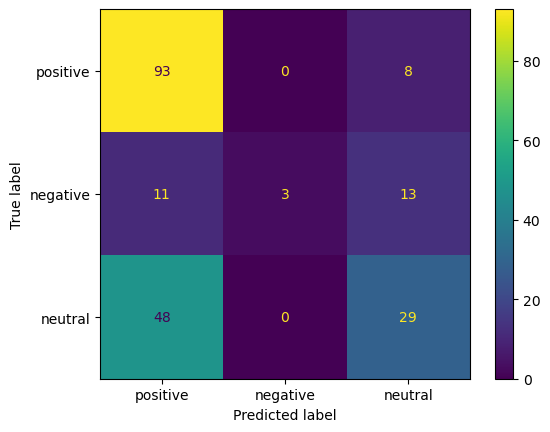

0.6097560975609756
              precision    recall  f1-score   support

    positive       1.00      0.11      0.20        27
    negative       0.58      0.38      0.46        77
     neutral       0.61      0.92      0.74       101

    accuracy                           0.61       205
   macro avg       0.73      0.47      0.46       205
weighted avg       0.65      0.61      0.56       205



In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data['Studium_Label'],
    student_data['sentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

# [2] Alteration of prompt towards more negative categorization
As demonstrated in the evaluation, GPT 3.5 exhibited a bias towards categorizing inputs into more positive sentiments. To improve the accuracy and achieve a more negative categorization tendency, GPT was presented with an altered prompt designed to influence its categorization towards negativity.

The same parameters, with temperature set to 0 and seed set to 123 as in the initial approach, were utilized for consistency.

In [6]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. However, if a text has negative aspects, have a higher tendency towards a negative rating. Only respond with either positive, neutral or negative."}

#Creation of a new data set
student_data_altered = student_data_unpr
student_data_altered = student_data_unpr.drop("Studium_Label", axis=1)

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data_altered.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            #Setting temperature to ensure objective responses
            temperature=0,
            #Setting the seed parameter to ensure more consistent results
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "alteredSentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)



# [2.1] Second evaluation 
In the second evaluation, GPT persists in demonstrating a bias towards positive categorization, with a reduced precision of 0.78 for positive sentiments, compared to the first evaluation. However, despite this bias, the overall F1 score shows an improvement, increasing by 4%. Nevertheless, GPT continues to struggle with accurately categorizing negative sentiments, correctly identifying only 27 out of 132 negatively labeled datasets.



In [7]:
#Merging target labels with predicted labels and dropping of duplicated row
results_df = results_df.drop("index", axis=1)
student_data_altered = pd.concat([student_data_unpr, results_df], axis=1)
student_data_altered = student_data_altered[student_data_altered["Studium_Label"].notnull()]

#Adding of altered predictions to a dataframe in order to save all predictions in an excel
altered_prediction = student_data_altered["alteredSentimentPrediction"]
student_data = pd.concat([student_data, altered_prediction], axis=1)


#Convertion of all values into strings
for x in student_data_altered:
    student_data[x] = student_data[x].astype(str)



In [8]:
#saving of data into an excel sheet
#student_data.to_excel("Evaluation.xlsx", index=False) 

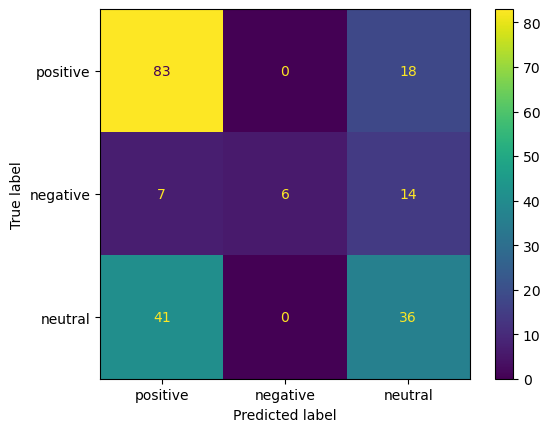

0.6097560975609756
              precision    recall  f1-score   support

    positive       1.00      0.22      0.36        27
    negative       0.53      0.47      0.50        77
     neutral       0.63      0.82      0.72       101

    accuracy                           0.61       205
   macro avg       0.72      0.50      0.53       205
weighted avg       0.64      0.61      0.59       205



In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data_altered['Studium_Label'], student_data_altered['alteredSentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data_altered['Studium_Label'], student_data_altered['alteredSentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data_altered['Studium_Label'],
    student_data_altered['alteredSentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

# [3] One shot learning with a negative and neutral example
As demonstrated in the second evaluation, GPT 3.5 exhibited a bias towards categorizing inputs into more positive sentiments, even after specifying a more negatife tendency.

To improve the accuracy and achieve a more negative categorization tendency, GPT was presented with one example for a negative data entry and a neutral entry.

The same parameters, with temperature set to 0 and seed set to 123 as in the initial approach, were utilized for consistency

In [10]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. However, if a text has negative aspects, have a higher tendency towards a negative rating. This is an example for a negative labeled dataset: 'Die City University of Hong Kong hat eine große Kursauswahl. Die Kurse gehen für gewöhnlich drei Stunden lang und sie haben einen hohen Workload (vor allem im letzten Drittel der Vorlesungszeit). Das Kursniveau generell nicht auf dem von Mannheim. Es könnte ein kultureller Unterschied sein, aber die Fragestellungen für Essays und Gruppenarbeiten sind oftmals sehr vage und breit gefasst. Auch die Bewertung ist intransparent, man erhält kein Feedback bevor man die Endnote für den Kurs erhält. Mein Semester ging von Ende August bis Ende November (Vorlesungszeit). Nach einer Woche Pause beginnt die zwei wöchige Prüfungszeit und endet vor Weihnachten. Ich hatte jedoch keine Klausur in der Prüfungsphase, alle Abgaben (Essays, Gruppenberichte) und Präsentationen/Tests liefen unter dem Semester.Die Mensen der CityU sind sehr empfehlenswert. Westliches und asiatisches Essen ist beides vorhanden. Vor allem die Desserts in AC1 sind eine große Empfehlung.Das Sprachniveau war sehr durchmischt, sowohl bei Professoren, als auch bei Studenten. Teils waren Fragestellungen in Prüfungen sprachlich schwer verständlich. In Restaurants kommt man gut damit aus auf die Bilder/Karte zu zeigen.' This is an example for a neutral dataset: 'Da ich während Corona vor Ort war habe ich die Uni nur zweimal besucht. Die restlichen Monate hatte ich nur Online Vorlesungen. Von den Professoren und den Mitarbeitern kann ich sagen, dasss alle sehr nett und hilfsbereit waren. Falls ihr Probleme oder Fragen habt sendet einfach eine Email an das Studienbüro und die werden euch helfen.' Only respond with either positive, neutral or negative."}

#Creation of a new data set
student_data_oneshot = student_data_unpr
student_data_oneshot = student_data_unpr.drop("Studium_Label", axis=1)

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data_oneshot.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            #Setting temperature to ensure objective responses
            temperature=0,
            #Setting the seed parameter to ensure more consistent results
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "oneshotSentimentPrediction": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)



# [3.1] One shot evaluation with a negative and neutral example 

In the third evaluation, GPT 3.5 demonstrated improved accuracy in categorizing negative data entries, achieving an increased precision of 0.68 for negative entries. Additionally, the overall F1 score improved to 0.65. However, it is noteworthy that neutral data entries also tend to be classified towards more negative categories.


In [13]:
#Merging target labels with predicted labels and dropping of duplicated row
#results_df = results_df.drop("index", axis=1)
student_data_oneshot = pd.concat([student_data_unpr, results_df], axis=1)
student_data_oneshot = student_data_oneshot[student_data_oneshot["Studium_Label"].notnull()]

#Adding of altered predictions to a dataframe in order to save all predictions in an excel
oneshot_prediction = student_data_oneshot["oneshotSentimentPrediction"]
student_data = pd.concat([student_data, oneshot_prediction], axis=1)


#Convertion of all values into strings
for x in student_data_oneshot:
    student_data[x] = student_data[x].astype(str)



In [14]:
#saving of data into an excel sheet
#student_data.to_excel("Evaluation_new.xlsx", index=False) 

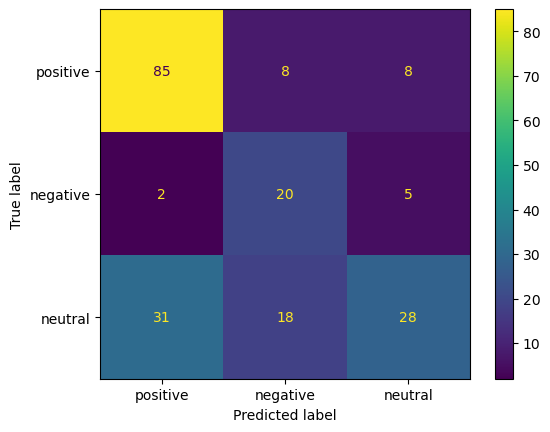

0.6487804878048781
              precision    recall  f1-score   support

    positive       0.43      0.74      0.55        27
    negative       0.68      0.36      0.47        77
     neutral       0.72      0.84      0.78       101

    accuracy                           0.65       205
   macro avg       0.61      0.65      0.60       205
weighted avg       0.67      0.65      0.63       205



In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data_oneshot['Studium_Label'], student_data_oneshot['oneshotSentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data_oneshot['Studium_Label'], student_data_oneshot['oneshotSentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data_oneshot['Studium_Label'],
    student_data_oneshot['oneshotSentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

# [4] One shot learning with a GPT 4o
As demonstrated in the third evaluation, GPT 3.5 is capable to categorize better into negative sentiments, when provided with a negative exampla. However, the neutral data entrys are not categorized accurately.

To improve the the overall accuracy
The same parameters, with temperature set to 0 and seed set to 123 as in the initial approach, were utilized for consistency

In [20]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. Only respond with either positive, neutral or negative."}

#Creation of a new data set
student_data_4o = student_data_unpr
student_data_4o = student_data_unpr.drop("Studium_Label", axis=1)

results=[]
results_df = []


# Sending labeling requests to GPT
for index, eintrag in student_data_4o.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
        model="gpt-4o",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            #Setting temperature to ensure objective responses
            temperature=0,
            #Setting the seed parameter to ensure more consistent results
            seed = 123
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction_4o": response.choices[0].message.content.lower()})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




# [4.1] One shot evaluation with a negative example


In the second evaluation, GPT persists in demonstrating a bias towards positive categorization, with a reduced precision of 0.78 for positive sentiments, compared to the first evaluation. However, despite this bias, the overall F1 score shows an improvement, increasing by 4%. Nevertheless, GPT continues to struggle with accurately categorizing negative sentiments, correctly identifying only 27 out of 132 negatively labeled datasets.



In [21]:
#Merging target labels with predicted labels and dropping of duplicated row
results_df = results_df.drop("index", axis=1)
student_data_4o = pd.concat([student_data_unpr, results_df], axis=1)
student_data_4o = student_data_4o[student_data_4o["Studium_Label"].notnull()]

#Adding of altered predictions to a dataframe in order to save all predictions in an excel
prediction_4o = student_data_4o["sentimentPrediction_4o"]
student_data = pd.concat([student_data, prediction_4o], axis=1)


#Convertion of all values into strings
for x in student_data_oneshot_negative:
    student_data[x] = student_data[x].astype(str)



In [22]:
#saving of data into an excel sheet
student_data.to_excel("Evaluation_new.xlsx", index=False) 

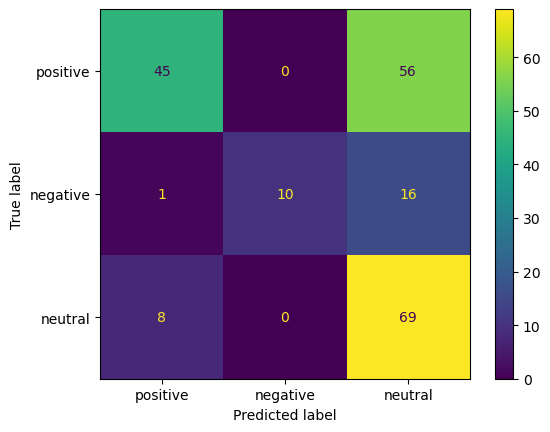

0.6048780487804878
              precision    recall  f1-score   support

    positive       1.00      0.37      0.54        27
    negative       0.49      0.90      0.63        77
     neutral       0.83      0.45      0.58       101

    accuracy                           0.60       205
   macro avg       0.77      0.57      0.58       205
weighted avg       0.73      0.60      0.60       205



In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data_4o['Studium_Label'], student_data_4o['sentimentPrediction_4o'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data_4o['Studium_Label'], student_data_4o['sentimentPrediction_4o'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data_4o['Studium_Label'],
    student_data_4o['sentimentPrediction_4o'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))